In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import pandas as pd
import numpy as np
import optuna
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC 

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\lenovo\MLops Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Loading Data...")
df = pd.read_csv("innings_2.csv")
# Pune Name Fix
df['batting_team'] = df['batting_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
df['bowling_team'] = df['bowling_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
df['match_won_by'] = df['match_won_by'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
# Target Column
df['result'] = df.apply(lambda x: 1 if x['batting_team'] == x['match_won_by'] else 0, axis=1)
print("✅ Data Loaded & Names Fixed.")

Loading Data...


C:\Users\lenovo\AppData\Local\Temp\ipykernel_22628\2265530076.py:2: DtypeWarning: Columns (28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("innings_2.csv")


✅ Data Loaded & Names Fixed.


In [4]:
# Feature Engineering
print("Engineering Features...")
df['current_score'] = df.groupby('match_id')['runs_total'].cumsum()
df['runs_needed'] = df['runs_target'] - df['current_score']
df['balls_bowled'] = (df['over']*6) + df['ball']
df['balls_left'] = 120 - df['balls_bowled']
df['wickets_fallen'] = df.groupby('match_id')['is_wicket'].cumsum()
df['wickets_left'] = 10 - df['wickets_fallen']
df['crr'] = (df['current_score']*6) / df['balls_bowled']
df['rrr'] = (df['runs_needed']*6) / df['balls_left']

# Cleanup (Infinity/Errors)
df.loc[df['balls_left'] == 0, 'rrr'] = 0 
df['crr'] = df['crr'].fillna(0)
df['rrr'] = df['rrr'].fillna(0)
df = df[df['balls_left'] > 0] 
df = df[df['runs_needed'] >= 0]
print("✅ Features Created.")

Engineering Features...
✅ Features Created.


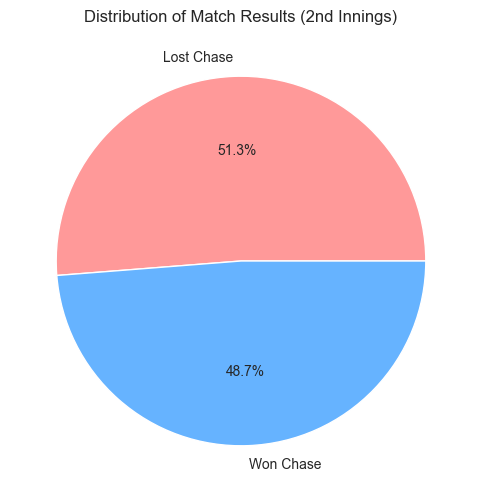

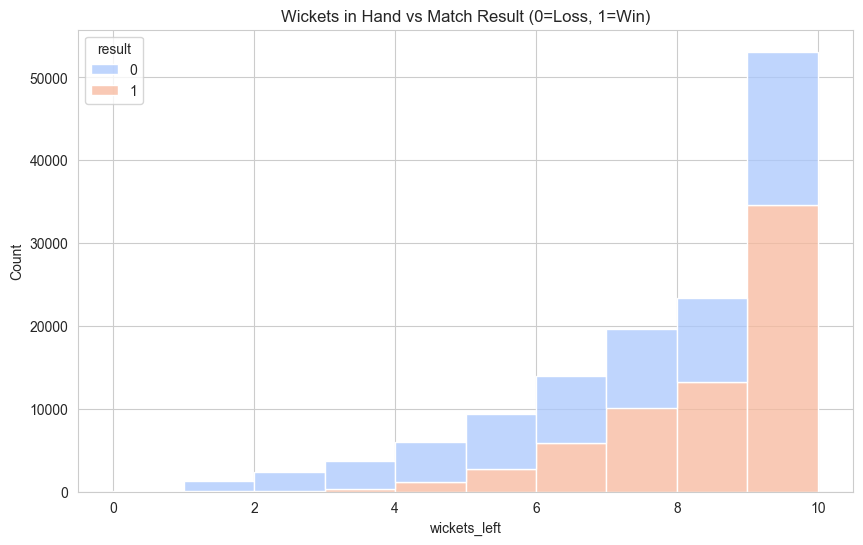

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22628\430700778.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['result'] == 1]['rrr'], label='Winners', shade=True, color='green')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_22628\430700778.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['result'] == 0]['rrr'], label='Losers', shade=True, color='red')


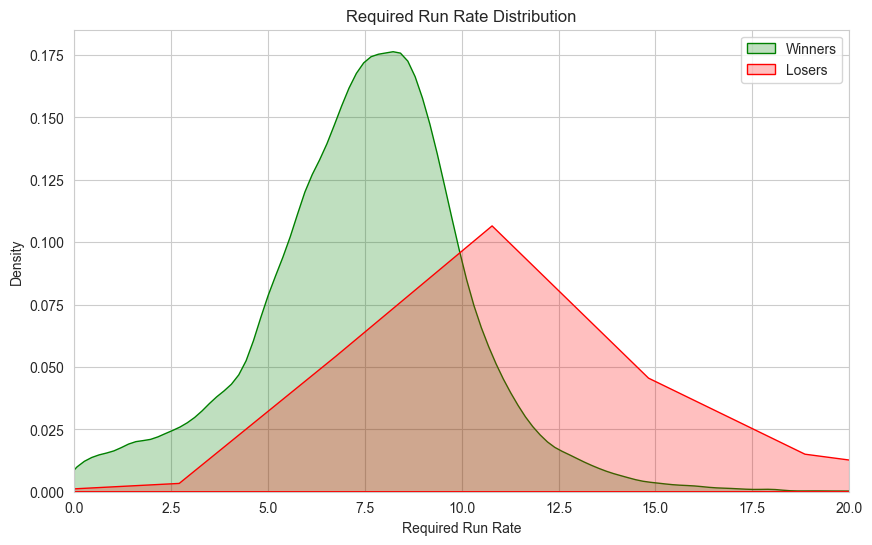

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visuals style
sns.set_style('whitegrid')

# 1. Target Balance (Win vs Loss in Chases)
plt.figure(figsize=(6, 6))
df['result'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], labels=['Lost Chase', 'Won Chase'])
plt.title('Distribution of Match Results (2nd Innings)')
plt.ylabel('')
plt.show()

# 2. Impact of Wickets Left on Winning
plt.figure(figsize=(10, 6))
sns.histplot(x='wickets_left', hue='result', data=df, multiple='stack', bins=10, palette='coolwarm')
plt.title('Wickets in Hand vs Match Result (0=Loss, 1=Win)')
plt.show()

# 3. Required Run Rate (RRR) Distribution for Winners vs Losers
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['result'] == 1]['rrr'], label='Winners', shade=True, color='green')
sns.kdeplot(df[df['result'] == 0]['rrr'], label='Losers', shade=True, color='red')
plt.title('Required Run Rate Distribution')
plt.xlabel('Required Run Rate')
plt.xlim(0, 20) # Limit extreme outliers
plt.legend()
plt.show()

In [6]:
# Features Selection
features = ['batting_team', 'bowling_team', 'city', 'runs_needed', 'balls_left', 'wickets_left', 'crr', 'rrr']
X = df[features]
y = df['result']
X.loc[:, 'city'] = X['city'].fillna('Unknown') 

# SPLITTING BY MATCH ID
match_ids = df['match_id'].unique()

# Separate Test Data (20%) 
train_val_match_ids, test_match_ids = train_test_split(match_ids, test_size=0.2, random_state=42)


train_match_ids, val_match_ids = train_test_split(train_val_match_ids, test_size=0.25, random_state=42) 
#So final split is 60% Train, 20% Val, 20% Test.

# Create Datasets using Masks
X_train = X[df['match_id'].isin(train_match_ids)]
y_train = y[df['match_id'].isin(train_match_ids)]

X_val = X[df['match_id'].isin(val_match_ids)]
y_val = y[df['match_id'].isin(val_match_ids)]

X_test = X[df['match_id'].isin(test_match_ids)]
y_test = y[df['match_id'].isin(test_match_ids)]

print(f"✅ Data Split Done!")
print(f"Train Rows: {len(X_train)} ")
print(f"Val Rows:   {len(X_val)} ")
print(f"Test Rows:  {len(X_test)}")

✅ Data Split Done!
Train Rows: 79582 
Val Rows:   26757 
Test Rows:  26656


In [7]:
# Preprocessing
cat_cols = ['batting_team', 'bowling_team', 'city']
num_cols = ['runs_needed', 'balls_left', 'wickets_left', 'crr', 'rrr']

trf = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost'])
    
    if classifier_name == 'RandomForest':
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
        rf_max_depth = trial.suggest_int('rf_max_depth', 5, 20)
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
        
        model = RandomForestClassifier(
            n_estimators=rf_n_estimators, max_depth=rf_max_depth, 
            min_samples_split=rf_min_samples_split, random_state=42, n_jobs=-1
        )
        
    else:
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
        xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3)
        
        model = XGBClassifier(
            n_estimators=xgb_n_estimators, 
            max_depth=xgb_max_depth, 
            learning_rate=xgb_learning_rate, 
            random_state=42, 
            use_label_encoder=False, 
            eval_metric='logloss',
            device='cuda',        
            tree_method='hist'    
        )

    pipeline = Pipeline([('preprocessor', trf), ('classifier', model)])
    
    # Fit on Train
    pipeline.fit(X_train, y_train)
    
    # Predict on VAL (Not Test) to tune hyperparameters
    val_accuracy = accuracy_score(y_val, pipeline.predict(X_val))
    
    return val_accuracy

print("✅ Objective Function Updated (Using Validation Set)!")

✅ Objective Function Updated (Using Validation Set)!


In [8]:
# Cell 5: Define Optuna Objective (No SVM, Only RF & XGB)
cat_cols = ['batting_team', 'bowling_team', 'city']
num_cols = ['runs_needed', 'balls_left', 'wickets_left', 'crr', 'rrr']

trf = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

def objective(trial):
    # Sirf 2 heavyweights rakhe hain ab
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost'])
    
    if classifier_name == 'RandomForest':
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
        rf_max_depth = trial.suggest_int('rf_max_depth', 5, 20)
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
        
        model = RandomForestClassifier(
            n_estimators=rf_n_estimators, max_depth=rf_max_depth, 
            min_samples_split=rf_min_samples_split, random_state=42, n_jobs=-1
        )
        
    else:
        # XGBoost with GPU
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
        xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3)
        
        model = XGBClassifier(
            n_estimators=xgb_n_estimators, 
            max_depth=xgb_max_depth, 
            learning_rate=xgb_learning_rate, 
            random_state=42, 
            use_label_encoder=False, 
            eval_metric='logloss',
            device='cpu',   
            n_jobs=-1,     
            tree_method='hist'    
        )

    pipeline = Pipeline([('preprocessor', trf), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    return accuracy_score(y_test, pipeline.predict(X_test))

print("✅ Objective Function Fixed (SVM Removed)!")

✅ Objective Function Fixed (SVM Removed)!


In [9]:
print("🚀 Starting Optuna Study...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25) 

print("\n" + "="*50)
print(f"🏆 Best Model: {study.best_params['classifier']}")
print(f"🎯 Best Accuracy: {study.best_value:.4f}")
print("="*50)
print("Best Params:", study.best_params)

[I 2026-01-09 00:32:14,057] A new study created in memory with name: no-name-4317f26a-868a-4a66-b6f2-a1d41bfec4b9


🚀 Starting Optuna Study...


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [00:32:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2026-01-09 00:32:17,499] Trial 0 finished with value: 0.7519507803121248 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 191, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.21276507398590822}. Best is trial 0 with value: 0.7519507803121248.
c:\Users\lenovo\MLops Project\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [00:32:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrai


🏆 Best Model: XGBoost
🎯 Best Accuracy: 0.8066
Best Params: {'classifier': 'XGBoost', 'xgb_n_estimators': 81, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.11015906307387772}


In [10]:
print("💾 Saving Final Best Model...")
best_params = study.best_params
final_model = None

if best_params['classifier'] == 'RandomForest':
    model = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'], 
        max_depth=best_params['rf_max_depth'], 
        min_samples_split=best_params['rf_min_samples_split'], 
        random_state=42, n_jobs=-1
    )
else: # XGBoost
    model = XGBClassifier(
        n_estimators=best_params['xgb_n_estimators'], 
        max_depth=best_params['xgb_max_depth'], 
        learning_rate=best_params['xgb_learning_rate'], 
        random_state=42, eval_metric='logloss',
        device='cuda',        
        tree_method='hist'
    )

final_pipeline = Pipeline([('preprocessor', trf), ('classifier', model)])
final_pipeline.fit(X_train, y_train)

pickle.dump(final_pipeline, open('pipe_optuna.pkl', 'wb'))
print(f"✅ DONE! {best_params['classifier']} model saved as 'pipe_optuna.pkl'")

💾 Saving Final Best Model...
✅ DONE! XGBoost model saved as 'pipe_optuna.pkl'


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("🕵️‍♂️ Checking Model Performance (Train vs Val vs Test)...")

# 1. Load the Saved Model
pipe = pickle.load(open('pipe_optuna.pkl', 'rb'))

# 2. Get Accuracies
train_acc = accuracy_score(y_train, pipe.predict(X_train))
val_acc   = accuracy_score(y_val, pipe.predict(X_val))
test_acc  = accuracy_score(y_test, pipe.predict(X_test))

# 3. Print Comparison
print(f"📈 Training Accuracy:   {train_acc*100:.2f}%")
print(f"⚖️ Validation Accuracy: {val_acc*100:.2f}% ")
print(f"🧪 Test Accuracy:       {test_acc*100:.2f}% ")

print("\n" + "="*40)
# Overfitting Check
if train_acc - test_acc > 0.10:
    print("WARNING: High Overfitting! (Model memorized the train data)")
elif train_acc - test_acc > 0.05:
    print("Caution: Slight Overfitting.")
else:
    print("✅ PERFECT MODEL! (Consistent performance across all sets)")
print("="*40)

# 4. Detailed Test Report
print("\n📝 Detailed Test Report:")
print(classification_report(y_test, pipe.predict(X_test)))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, pipe.predict(X_test))
print("Confusion Matrix:\n", cm)

🕵️‍♂️ Checking Model Performance (Train vs Val vs Test)...


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\xgboost\core.py:774: UserWarning: [00:32:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unkno

📈 Training Accuracy:   81.99%
⚖️ Validation Accuracy: 75.71% 
🧪 Test Accuracy:       80.66% 

✅ PERFECT MODEL! (Consistent performance across all sets)

📝 Detailed Test Report:


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.80      0.79     11854
           1       0.83      0.81      0.82     14802

    accuracy                           0.81     26656
   macro avg       0.80      0.81      0.80     26656
weighted avg       0.81      0.81      0.81     26656



c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Confusion Matrix:
 [[ 9455  2399]
 [ 2756 12046]]


C:\Users\lenovo\AppData\Local\Temp\ipykernel_22628\3233745090.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


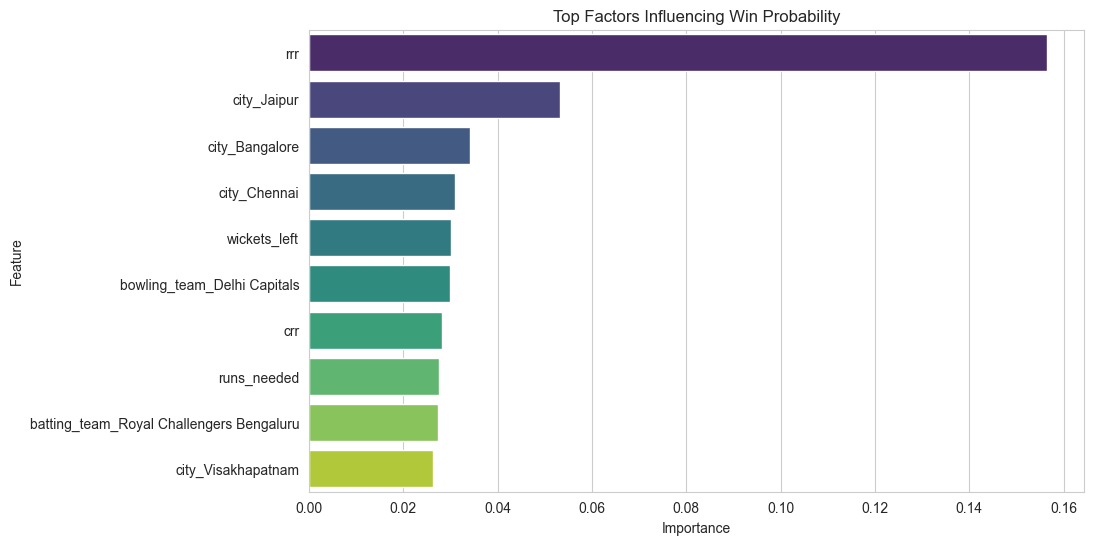

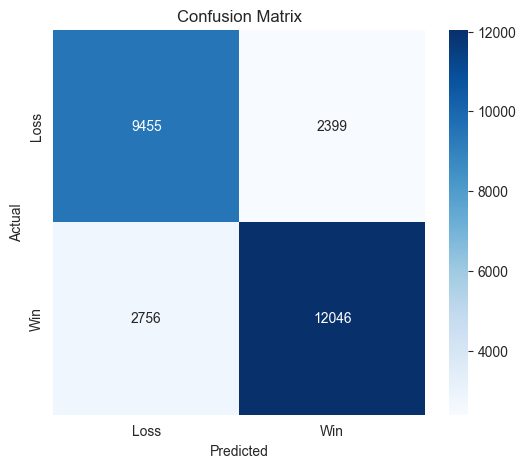

In [12]:
# --- 1. Feature Importance Plot ---
model_step = pipe.named_steps['classifier']
preprocessor_step = pipe.named_steps['preprocessor']

# Get Feature Names (Encoded + Numerical)
ohe_cols = preprocessor_step.named_transformers_['ohe'].get_feature_names_out()
all_features = list(ohe_cols) + num_cols

# Plot Top 10 Features
importances = model_step.feature_importances_
feat_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('Top Factors Influencing Win Probability')
plt.show()

# --- 2. Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Loading Data & Model...


C:\Users\lenovo\AppData\Local\Temp\ipykernel_22628\2497841283.py:10: DtypeWarning: Columns (28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("innings_2.csv")


Merging Year info...
Processing Data...

📊 Year-wise Accuracy Report:
---------------------------------------------
Year       | Accuracy   | Matches   
---------------------------------------------
2008       | 82.01%     | 58
2009       | 78.98%     | 57
2010       | 81.58%     | 60
2011       | 88.26%     | 72


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


2012       | 77.57%     | 74
2013       | 81.34%     | 76
2014       | 80.44%     | 60
2015       | 79.71%     | 57
2016       | 81.67%     | 60
2017       | 75.08%     | 59
2018       | 72.91%     | 60
2019       | 77.03%     | 59
2020       | 79.87%     | 60
2021       | 81.36%     | 60
2022       | 84.70%     | 74
2023       | 78.01%     | 73
2024       | 84.39%     | 71
2025       | 80.90%     | 71


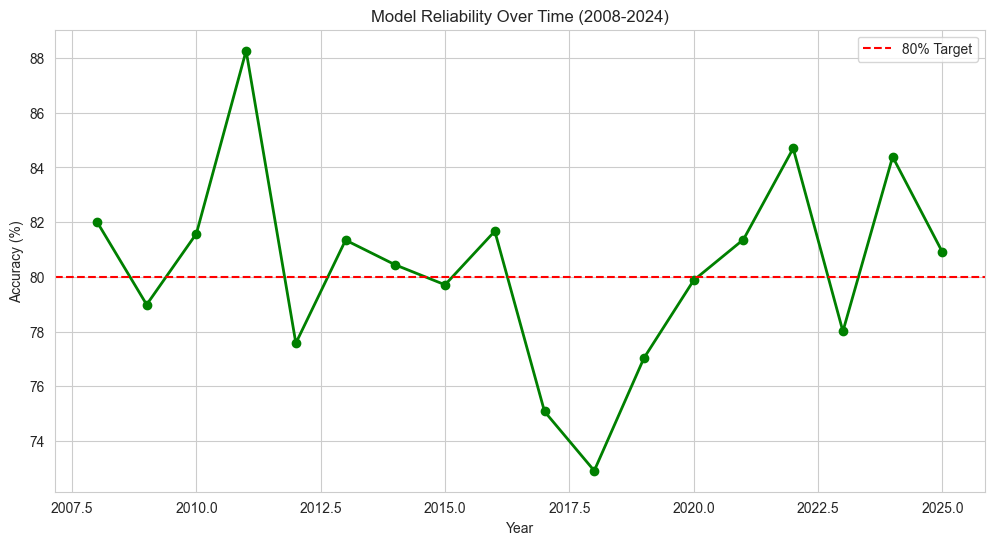

In [13]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sys

# 1. Load Data & Model
print("Loading Data & Model...")
try:
    df = pd.read_csv("innings_2.csv")
    matches = pd.read_csv("matches.csv") 
    pipe = pickle.load(open('pipe_optuna.pkl', 'rb'))
except FileNotFoundError as e:
    print(f"❌ Error: File nahi mili - {e}")
    sys.exit()

# 2. Merge Year Information (Smart Logic) 🧠
print("Merging Year info...")

# Check Season Column Name
season_col = 'Season' if 'Season' in matches.columns else 'season'

# Check ID Column Name (Ye hai Error ka Fix)
if 'id' in matches.columns:
    right_col = 'id'
elif 'match_id' in matches.columns:
    right_col = 'match_id'
else:
    print("❌ Error: matches.csv mein ID column nahi mila!")
    print("Columns available:", matches.columns)
    sys.exit()

# Merge
df = df.merge(matches[[right_col, season_col]], left_on='match_id', right_on=right_col)
df.rename(columns={season_col: 'year'}, inplace=True)

# 3. Data Cleaning & Feature Engineering (Same as before)
print("Processing Data...")
df['batting_team'] = df['batting_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
df['bowling_team'] = df['bowling_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
df['match_won_by'] = df['match_won_by'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')

df['result'] = df.apply(lambda x: 1 if x['batting_team'] == x['match_won_by'] else 0, axis=1)
df['current_score'] = df.groupby('match_id')['runs_total'].cumsum()
df['runs_needed'] = df['runs_target'] - df['current_score']
df['balls_bowled'] = (df['over']*6) + df['ball']
df['balls_left'] = 120 - df['balls_bowled']
df['wickets_fallen'] = df.groupby('match_id')['is_wicket'].cumsum()
df['wickets_left'] = 10 - df['wickets_fallen']
df['crr'] = (df['current_score']*6) / df['balls_bowled']
df['rrr'] = (df['runs_needed']*6) / df['balls_left']

# Cleanup
df.loc[df['balls_left'] == 0, 'rrr'] = 0 
df['crr'] = df['crr'].fillna(0)
df['rrr'] = df['rrr'].fillna(0)
df = df[df['balls_left'] > 0] 
df = df[df['runs_needed'] >= 0]
df['city'] = df['city'].fillna('Unknown')

# 4. Accuracy Check Loop
years = sorted(df['year'].unique())
accuracies = []

print("\n📊 Year-wise Accuracy Report:")
print("-" * 45)
print(f"{'Year':<10} | {'Accuracy':<10} | {'Matches':<10}")
print("-" * 45)

for year in years:
    year_data = df[df['year'] == year]
    
    # Features for Prediction
    X_year = year_data[['batting_team', 'bowling_team', 'city', 'runs_needed', 'balls_left', 'wickets_left', 'crr', 'rrr']]
    y_year = year_data['result']
    
    # Prediction
    y_pred = pipe.predict(X_year)
    acc = accuracy_score(y_year, y_pred)
    accuracies.append(acc)
    
    print(f"{year:<10} | {acc*100:.2f}%     | {year_data['match_id'].nunique()}")

# 5. Plot Graph
plt.figure(figsize=(12, 6))
plt.plot(years, [a*100 for a in accuracies], marker='o', color='green', linewidth=2)
plt.axhline(y=80, color='r', linestyle='--', label="80% Target")
plt.title("Model Reliability Over Time (2008-2024)")
plt.xlabel("Year")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()